In [2]:
import pandas as pd
import janitor
import numpy as np
import gc
from utilities.utils import get_fulldata, process_land_area
from utilities.graph_utils import save_mpl_fig
from utilities.utils import pandas_to_tex
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.5, style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

FP_CASTE_XWALK = "../data/caste_codes/caste_code_landrecords.dta"

In [13]:
usecols = ['account_no', "name_of_ryot", 'caste', '6', '7', '8']
ordered_caste_groups = ["uc", "bc2", "ebc", "sc", "st"]

df = (
    get_fulldata(**{'usecols':usecols, 'low_memory': False})
    .pipe(process_land_area)
      .merge(
          # Read in castecodes
          (pd
           .read_stata(FP_CASTE_XWALK)
           .select_columns(["caste_landrecords", "caste_category"])
           .rename_column("caste_landrecords", "caste")
           .drop_duplicates(subset=['caste'])
          ),
          how="left",
          on="caste",
          validate="m:1",
      )
      .dropna(subset=["caste_category"])
      .assign(
          caste_category=lambda df: pd.Categorical(df["caste_category"], categories=ordered_caste_groups, ordered=True)
      )
)

df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 26190330 entries, 0 to 38589907
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   name_of_ryot    object  
 1   caste           object  
 2   account_no      int64   
 3   acres           float64 
 4   decimals        float64 
 5   hectare         float64 
 6   tt_area_acre    float64 
 7   caste_category  category
dtypes: category(1), float64(4), int64(1), object(2)
memory usage: 1.6+ GB


,name_of_ryot,caste,account_no,acres,decimals,hectare,tt_area_acre,caste_category
0,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,66.0,0.0,0.66,uc
1,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,8.0,0.0,0.08,uc
2,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,6.0,0.0,0.06,uc
3,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,3.0,0.0,0.03,uc
4,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,36.0,0.0,0.36,uc
...,...,...,...,...,...,...,...,...
38589903,मु. मंचनिया,कोइरी,1402151675000018,0.0,9.0,0.0,0.09,bc2
38589904,मु. मंचनिया,कोइरी,1402151675000018,0.0,11.0,0.0,0.11,bc2
38589905,मु. मंचनिया,कोइरी,1402151675000018,0.0,6.0,0.0,0.06,bc2
38589906,मु. मंचनिया,कोइरी,1402151675000018,0.0,11.0,0.0,0.11,bc2


In [14]:
df["account_no"].nunique()

7060333

In [15]:
df["name_of_ryot"].nunique()

1825583

## Summary numbers

In [16]:
table = (
    df
    .groupby("caste_category")
    .agg({"caste_category": "count"})
    .set_axis(["pct"], axis=1)
    .assign(pct=lambda df: 100*df["pct"]/df["pct"].sum())
    .round(1)
    .reset_index()
)
table

,caste_category,pct
0,uc,39.4
1,bc2,37.2
2,ebc,16.2
3,sc,6.2
4,st,0.9


In [5]:
ind_table = (
    df
    .drop_duplicates("account_no")
    .groupby("caste_category")
    .agg({"caste_category": "count"})
    .set_axis(["pct"], axis=1)
    .assign(pct=lambda df: 100*df["pct"]/df["pct"].sum())
    .round(1)
    .reset_index()
)
ind_table

,caste_category,pct
0,uc,32.9
1,bc2,34.9
2,ebc,20.5
3,sc,10.5
4,st,1.1


In [4]:
df_num_plots = (df
                .groupby(["account_no", "caste_category"])
                .size()
                .reset_index()
                .rename_column(0, 'nplots')
                .query("nplots>0")
               )
df_num_plots.head(3)

,account_no,caste_category,nplots
1,101010273000001,bc2,2
6,101010273000002,bc2,8
11,101010273000003,bc2,1


## Number of plots per account, by religion

In [5]:
def create_tab_nplot_perc(df, col, val):
    ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
    tab_nplot_perc = (df
                      .query(f"{col}=='{val}'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', f'nplots_{val.lower()}')
                      .astype({f"nplots_{val.lower()}":int})
                      .set_index("Percentile")
                     )
    return tab_nplot_perc

# Create the table of percentiles for each group
for group in ordered_caste_groups:
    exec(f"tab_nplot_perc_{group} = create_tab_nplot_perc(df_num_plots, 'caste_category', '{group}')")
tab_nplot_perc_bc2

,nplots_bc2
Percentile,
0.00,1
0.10,1
0.20,1
0.30,1
0.40,1
0.50,1
0.60,2
0.70,3
0.80,5


In [6]:
# Get the names of the five tables
tab_nplot_perc_tabnames = [var for var in locals() if var.startswith('tab_nplot_perc')]
# Convert the list of names into the tables
tab_nplot_perc_tabs = [eval(tab_name) for tab_name in tab_nplot_perc_tabnames]

# Concatenate the list of tables
tab_nplot_perc = (pd.concat(tab_nplot_perc_tabs, axis=1)
                  .reset_index()
                 )
pandas_to_tex(tab_nplot_perc, "../tables/percentiles_landplots_per_accountholder_caste5", float_format="%.2f")
tab_nplot_perc

,Percentile,nplots_uc,nplots_bc2,nplots_ebc,nplots_sc,nplots_st
0,0.00,1,1,1,1,1
1,0.10,1,1,1,1,1
2,0.20,1,1,1,1,1
3,0.30,1,1,1,1,1
4,0.40,1,1,1,1,1
5,0.50,2,1,1,1,1
6,0.60,2,2,2,1,2
7,0.70,3,3,2,2,2
8,0.80,5,5,3,2,4
9,0.90,11,9,6,4,7


## Number of plots per account, by caste category (5 categories)

In [7]:
LINESTYLES = ["-", "--", ":", "-.", (0, (3, 5, 1, 5, 1, 5))]

DISPLOT_OPTS = dict(
    aspect=1.5,
    height=6,
    hue="caste_category",
    legend=False,
    palette="cividis",
    linewidth=2.5,
)
HISTDENSITY_OPTS = dict(
    hue="caste_category",
    legend=False,
    palette="cividis",
)

LEGEND_OPTS = {"title":"", 
               "loc":'best', 
               "labels":["ST", "SC", "EBC", "BC2", "UC"], 
               "frameon":False, 
               "fontsize":24, 
               "handletextpad":0.3
              }
# cutoff = 0.95  # percentile to trim at 

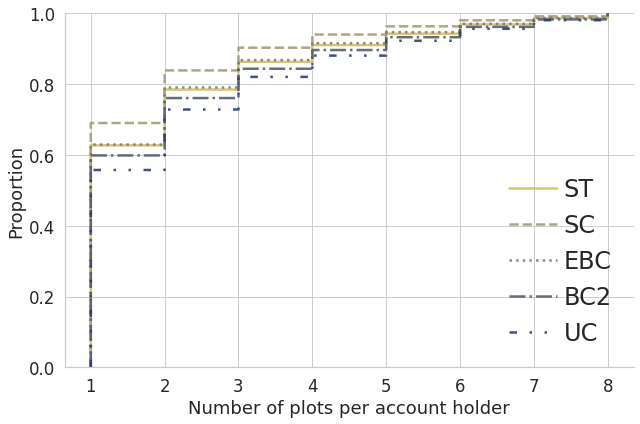

In [8]:
# Empirical CDF of #plots owned per account (fold cell)
_n = 8

g = sns.displot(
    x="nplots", 
    data=df_num_plots.query(f"nplots<={_n}"), 
    alpha=0.9,
    kind="ecdf",
#     hue="caste_category",
#     palette="cividis",
#     aspect=1.5,
#     height=6,
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Number of plots per account holder")
save_mpl_fig('../figures/number_plots_per_accountholder_ecdf_caste5')

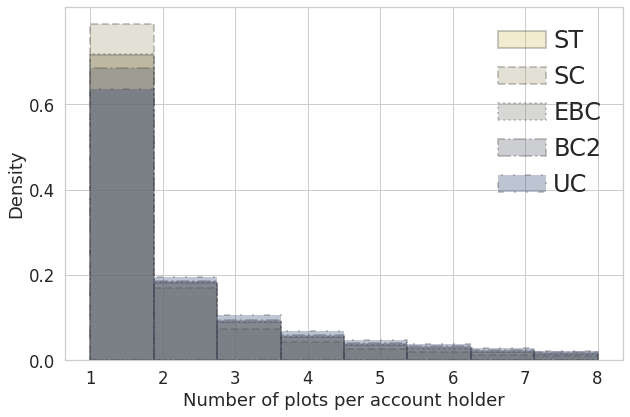

In [9]:
# Histogram of #plots owned per account (fold cell)
_, ax = plt.subplots(figsize=(10,6.5))
sns.histplot(data=df_num_plots.query(f"nplots<={_n}"),
             x='nplots', 
             bins=_n, 
             stat='density', 
             common_norm=False,
             **HISTDENSITY_OPTS,
             alpha=.5,
             ax=ax,
            )
plt.xlabel("Number of plots per account holder")
plt.yticks([0, 0.2,.4,.6])

bars = ax.containers[0].get_children()
for ix, _ in enumerate(ordered_caste_groups):
    bars = ax.containers[ix].get_children()
    for bar in bars:
        bar.set_linestyle(LINESTYLES[ix])
        bar.set_linewidth(2)
        bar.set_edgecolor("0.3")
        bar.set_alpha(.3)
plt.legend(**LEGEND_OPTS)    
save_mpl_fig('../figures/number_plots_per_accountholder_histogram_caste5')

## Land area per account, by caste category (5 categories)

In [10]:
df_landarea = (df
               .groupby(["account_no", "caste_category"])["tt_area_acre"]
               .sum()
               .reset_index()
               .query("tt_area_acre>0")
              )
df_landarea.head(3)

,account_no,caste_category,tt_area_acre
1,101010273000001,bc2,0.585
6,101010273000002,bc2,1.545
11,101010273000003,bc2,0.080


In [11]:
def create_tab_nplot_perc(df, col, val):
    ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
    tab_area_perc = (df
                      .query(f"{col}=='{val}'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', f'tt_area_acre_{val.lower()}')
                      .set_index("Percentile")
                     .assign(
                         **{f"tt_area_acre_{val.lower()}": lambda df: df[f"tt_area_acre_{val.lower()}"].map('{:,.2f}'.format)},
                     )                        
                    )
    return tab_area_perc

# Create the table of percentiles for each group
for group in ordered_caste_groups:
    exec(f"tab_area_perc_{group} = create_tab_nplot_perc(df_landarea, 'caste_category', '{group}')")
tab_area_perc_bc2

,tt_area_acre_bc2
Percentile,
0.00,0.00
0.10,0.04
0.20,0.09
0.30,0.15
0.40,0.24
0.50,0.36
0.60,0.55
0.70,0.83
0.80,1.34


In [12]:
# Get the names of the five tables
tab_area_perc_tabnames = [var for var in locals() if var.startswith('tab_area_perc')]
# Convert the list of names into the tables
tab_area_perc_tabs = [eval(tab_name) for tab_name in tab_area_perc_tabnames]

# Concatenate the list of tables
tab_area_perc = (pd.concat(tab_area_perc_tabs, axis=1)
                  .reset_index()
                 )
pandas_to_tex(tab_area_perc, "../tables/percentiles_landarea_per_accountholder_caste5", float_format="%.2f")
tab_area_perc

,Percentile,tt_area_acre_uc,tt_area_acre_bc2,tt_area_acre_ebc,tt_area_acre_sc,tt_area_acre_st
0,0.00,0.00,0.00,0.00,0.00,0.00
1,0.10,0.06,0.04,0.03,0.02,0.03
2,0.20,0.12,0.09,0.06,0.03,0.05
3,0.30,0.21,0.15,0.10,0.05,0.10
4,0.40,0.32,0.24,0.15,0.08,0.18
5,0.50,0.49,0.36,0.23,0.13,0.29
6,0.60,0.73,0.55,0.35,0.21,0.46
7,0.70,1.13,0.83,0.53,0.34,0.73
8,0.80,1.92,1.34,0.85,0.57,1.17
9,0.90,3.87,2.62,1.61,1.05,2.22


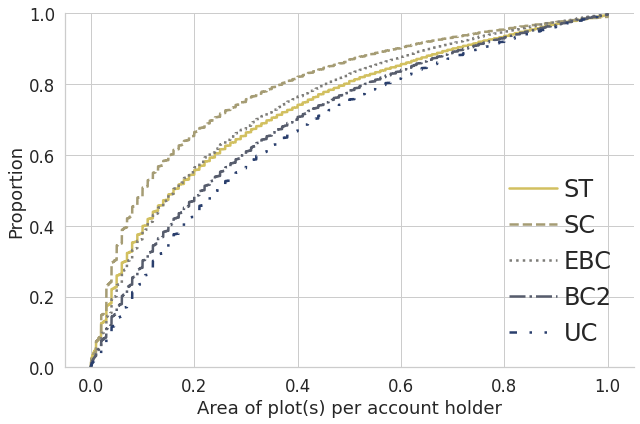

In [13]:
# Empirical CDF of land plot area owned per account (fold cell)
_area = 1
g = sns.displot(
    x="tt_area_acre", 
    data=df_landarea.query(f"tt_area_acre<={_area}"), 
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Area of plot(s) per account holder")
save_mpl_fig('../figures/plot_area_per_accountholder_ecdf_caste5')

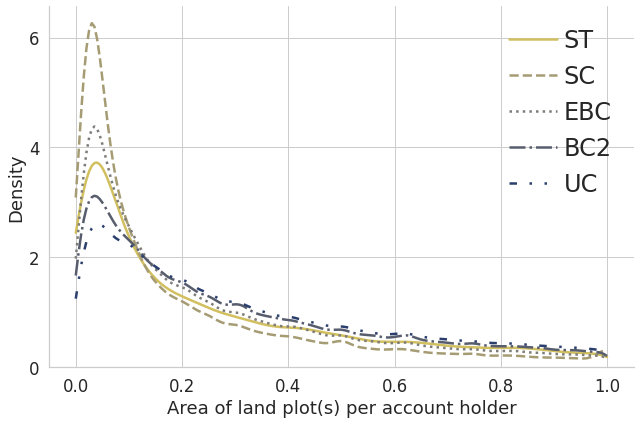

In [14]:
# Histogram of land plot area owned per account (fold cell)
g = sns.displot(data=df_landarea.query(f"tt_area_acre<={_area}"), 
                x="tt_area_acre", 
                kind='kde',
                common_norm=False,
                **DISPLOT_OPTS,
                cut=0
                )
g.set_xlabels("Area of land plot(s) per account holder")
plt.locator_params(axis="y", nbins=5)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
save_mpl_fig('../figures/plot_area_per_accountholder_kde_caste5')